In [1]:
import numpy as np
from collections import Counter
from itertools import product
from qiskit import *
from qiskit.algorithms.optimizers import SPSA
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams["font.size"] = 25
RANDOM_STATE = 25
np.random.seed(RANDOM_STATE)

In [2]:
class SPSACallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

## Generating  random data 

In [3]:
from generate_data import gaussian_copula,convert_data_to_binary_string,empirical_distribution

P_3 = np.array([[ 1.0, 0.3,  0.2],
              [0.3,  1.0,  -0.7],
              [ 0.2,  -0.7,  1.0]])

P_2 = np.array([[ 1.0, 0.7],
              [0.7,1]])
NUM_QUBITS_VAR = 3
NUM_VARS = len(P_2)
NUM_TRAINING_SAMPLES = 10000

cholesky,Z, U, G = gaussian_copula(NUM_TRAINING_SAMPLES,P_2)
binary_samples = convert_data_to_binary_string(U,NUM_QUBITS_VAR)
target_probs = empirical_distribution(binary_samples, NUM_QUBITS_VAR*NUM_VARS)

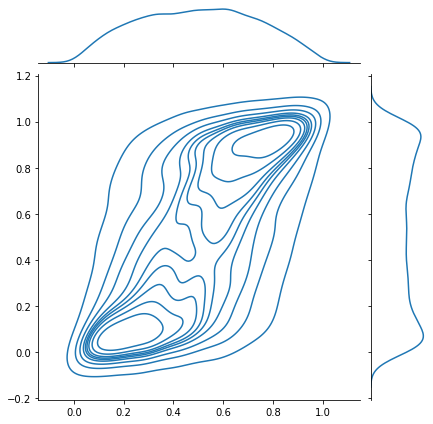

In [4]:
sns.jointplot(x=U[:,1], y=U[:,0], kind="kde");

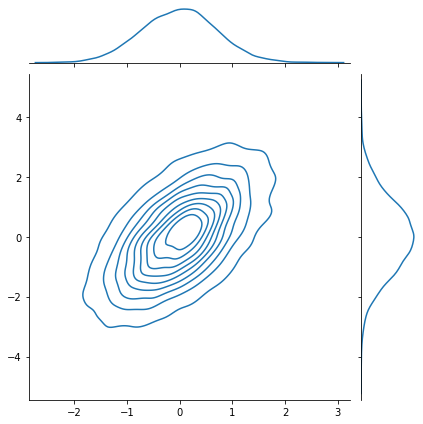

In [5]:
sns.jointplot(x=G[:,1], y=G[:,0], kind="kde");

In [6]:
NUM_LAYERS = 2
NUM_SHOTS = 2048
NUM_ITERS = 600
spsa_cbk = SPSACallback()
spsa = SPSA(maxiter=NUM_ITERS,callback=spsa_cbk.callback,learning_rate = 0.1,perturbation=0.1)

## Optimizing the QCBM model

In [7]:
from qcbm import QCBM
import time

qcbm_model = QCBM(NUM_QUBITS_VAR,NUM_VARS,NUM_LAYERS,NUM_SHOTS,target_probs)
cost_function = qcbm_model.cost_function
initial_params = 2*np.pi*np.random.rand(3, NUM_QUBITS_VAR*NUM_VARS, NUM_LAYERS).flatten()
start = time.time()
result = spsa.minimize(cost_function, initial_params)
end = time.time()
print("The optimization took : {} after {} epochs",end-start,NUM_ITERS)

The optimization took : {} after {} epochs 53.34875822067261 600


## Visualizing the loss curve

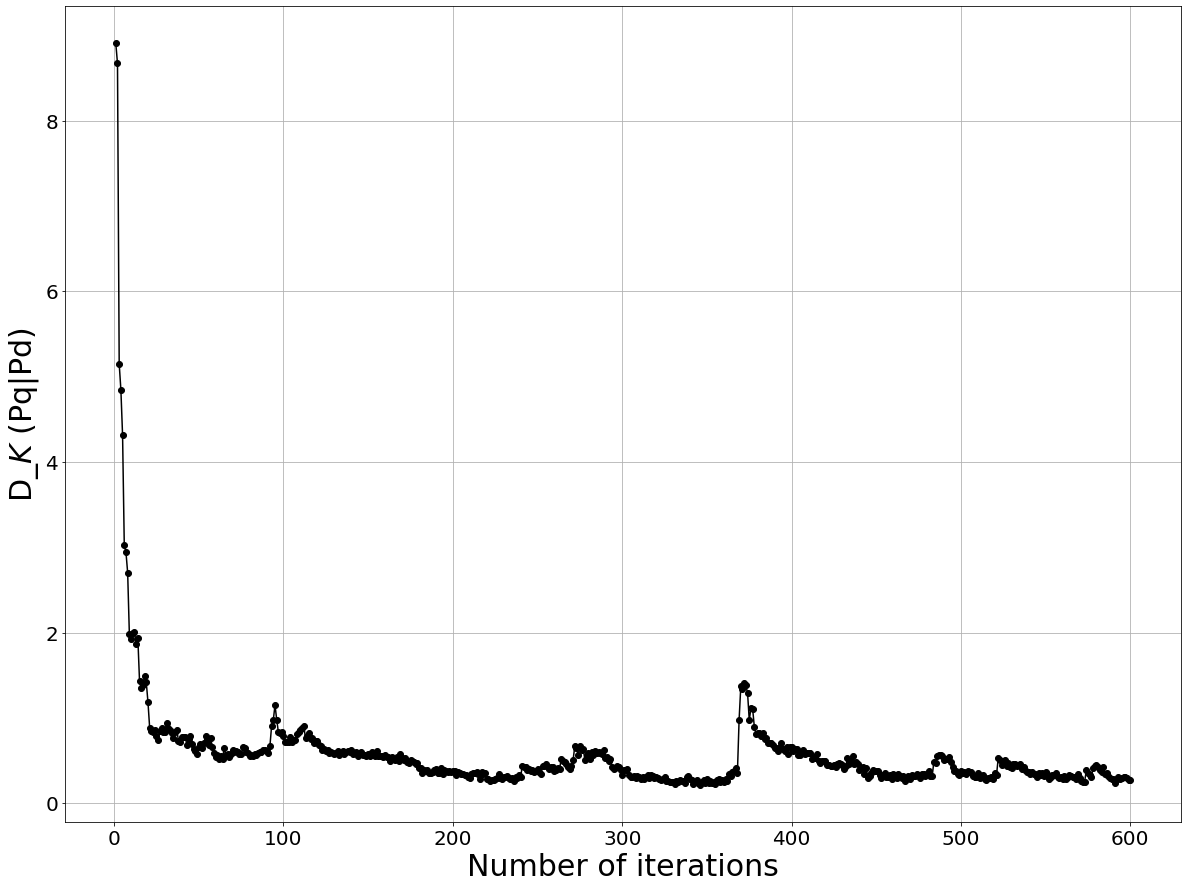

In [8]:
plt.rcParams["figure.figsize"] = (20,15)
plot_data = spsa_cbk.get_callback_data()  # callback data
plt.plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
plt.xlabel("Number of iterations")
plt.ylabel("D_$K$ (Pq|Pd)")
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid()
plt.show()

## Comparing learned and target distributions

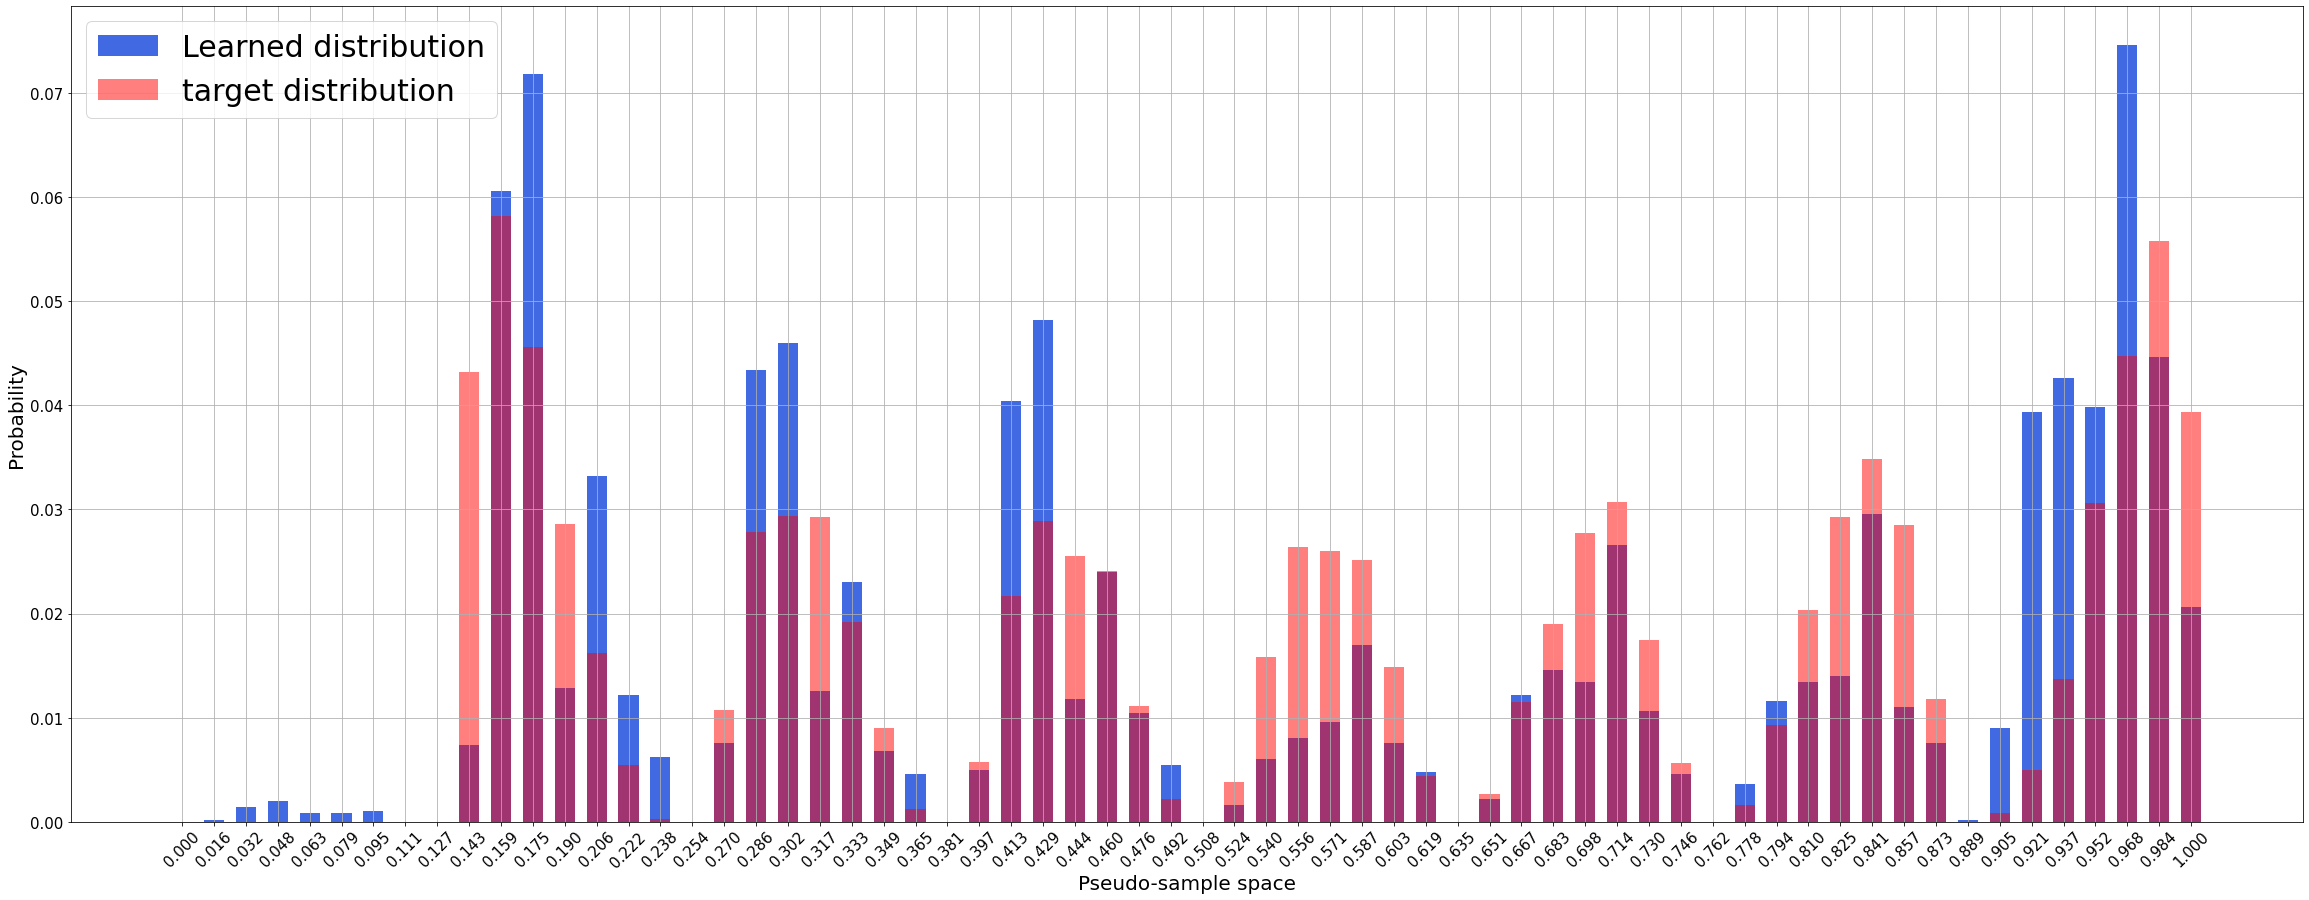

In [9]:
# Evaluate trained probability distribution by comapring histograms 
plt.rcParams["figure.figsize"] = (40,15)
bounds = [0,1]
num_qubits = NUM_QUBITS_VAR*NUM_VARS

x = [bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)]

opt_params = result.x
y = qcbm_model.estimate_distribution(opt_params,num_shots= 5000)

# Plot distributions
plt.bar(x, y, width=0.01, label="Learned distribution", color="royalblue")
plt.xticks(x, size=15, rotation=45)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Pseudo-sample space", size=20)
plt.ylabel("Probability", size=20)
plt.bar(x,target_probs,width=0.01,color="RED",label="target distribution",alpha = 0.5)
plt.legend(loc="best")
plt.show()

In [10]:
print(result)

{   'fun': 0.30916280196113516,
    'jac': None,
    'nfev': 1800,
    'nit': 600,
    'njev': None,
    'x': array([ 2.7679154 , -1.24917679,  0.50035279,  5.93826385,  2.88021351,
       -0.07625934, -0.51777766,  1.39503455, -1.19265307,  5.91346785,
        1.40735688,  5.10651082,  2.35763841, -0.59496809,  1.04715773,
       -2.16548093,  1.26657808, -0.1358654 ,  1.06248723,  3.2637841 ,
        0.90671969,  2.36927878,  1.68513267,  6.25077836,  6.743732  ,
        5.74210188,  7.37742557,  8.65881333,  3.89068483,  3.85586845,
       -1.72198459, -0.36158635,  5.54923875,  1.73025038, -0.93488293,
        5.31019548])}


## Sampling from the QCBM after reverse probability integral transform and compare with original random data

In [11]:
import importlib
import qcbm
from qcbm import QCBM
qcbm_model = QCBM(NUM_QUBITS_VAR,NUM_VARS,NUM_LAYERS,NUM_SHOTS,target_probs)
importlib.reload(qcbm)

<module 'qcbm' from '/home/ricardogagu/Escritorio/Quantum Computing/MoodysProblem/Copula-based-QCBM-estimation/qcbm.py'>

In [12]:
opt_params = result.x
U_qcbm  = qcbm_model.sample(opt_params,num_shots= 10000)

/home/ricardogagu/anaconda3/envs/copulaQC/lib/python3.9/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


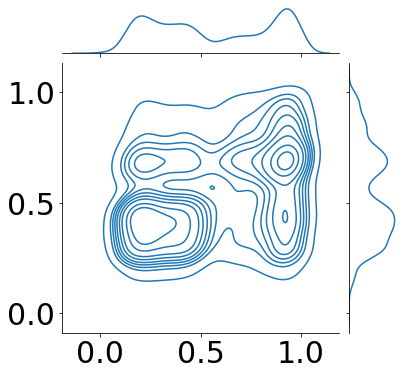

In [14]:
sns.jointplot(x=U_qcbm[:,1], y=U_qcbm[:,0], kind="kde");

/home/ricardogagu/anaconda3/envs/copulaQC/lib/python3.9/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


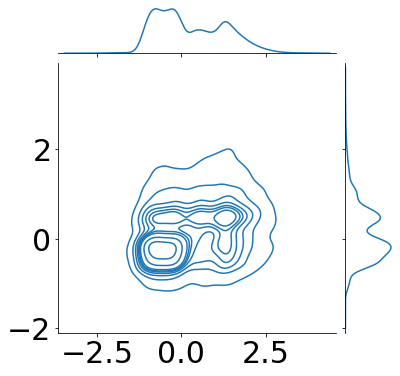

In [15]:
import scipy as sp
G_qcbm = sp.stats.norm.ppf(U_qcbm)
sns.jointplot(x=G_qcbm[:,1], y=G_qcbm[:,0], kind="kde");